# Import Libraries & Data

In [81]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
from scipy import signal
import mne
import matplotlib.pyplot as plt

In [13]:
data_path = '../../data/071424_OSCAR_SSVEP.csv'
df = pd.read_csv(data_path)

In [14]:
df

,Unnamed: 0,EEG_Ch1(mV),EEG_Ch2(mV),EEG_Ch3(mV),EEG_Ch4(mV),EEG_Ch5(mV),EEG_Ch6(mV),EEG_Ch7(mV),EEG_Ch8(mV),Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,stim
0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.054,0.970,0.059,0.000,0.000,0.000,1.0,86.667,1.0,0.000,0.0
1,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.047,0.995,0.053,0.000,0.000,0.000,2.0,86.667,1.0,9.522,0.0
2,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.043,1.003,0.049,0.000,0.000,0.000,3.0,86.667,1.0,2.250,0.0
3,3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.043,1.003,0.048,0.000,0.000,0.000,4.0,86.667,1.0,6.307,0.0
4,4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.046,1.004,0.047,0.000,0.000,0.000,5.0,86.667,1.0,3.731,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265152,265152,-7.515,6.170,5.388,-4.798,10.873,11.286,-1.504,-2.912,0.056,1.001,0.117,-1.404,-0.305,-1.892,265153.0,86.667,1.0,2.477,0.0
265153,265153,-6.695,7.132,2.894,-6.721,10.388,9.167,-1.475,-1.670,0.058,0.996,0.116,-1.556,-0.580,-1.984,265154.0,86.667,1.0,0.008,0.0
265154,265154,-6.214,8.223,0.014,-7.937,10.189,6.860,-1.428,-0.039,0.060,0.995,0.115,-1.526,-0.977,-2.014,265155.0,86.667,1.0,6.958,0.0
265155,265155,-6.060,8.873,-2.340,-8.777,10.043,4.627,-1.326,1.886,0.061,0.994,0.115,-1.282,-1.129,-2.075,265156.0,86.667,1.0,8.040,0.0


In [33]:
channels = [f"EEG_Ch{i}(mV)" for i in range(5, 8)] # Select channels you want
eeg_data = df[channels].to_numpy()
y = df['stim'].to_numpy()

n_channels = eeg_data.shape[1]

# Epoch Data & CCA Analysis

In [34]:
class CCAAnalysis:
    """Canonical Correlation Analysis for SSVEP paradigm"""
    def __init__(self, freqs, win_len, s_rate, n_harmonics=1):
        """
        Args:
            freqs (list): List of target frequencies
            win_len (float): Window length
            s_rate (int): Sampling rate of EEG signal
            n_harmonics (int): Number of harmonics to be considered
        """
        self.freqs = freqs
        self.win_len = win_len
        self.s_rate = s_rate
        self.n_harmonics = n_harmonics
        self.train_data = self._init_train_data()
        self.cca = CCA(n_components=1)

    def _init_train_data(self):
        t_vec = np.linspace(0, self.win_len, int(self.s_rate * self.win_len))
        targets = {}
        for freq in self.freqs:
            sig_sin, sig_cos = [], []
            for harmonics in range(self.n_harmonics):
                sig_sin.append(np.sin(2 * np.pi * harmonics * freq * t_vec))
                sig_cos.append(np.cos(2 * np.pi * harmonics * freq * t_vec))
            targets[freq] = np.array(sig_sin + sig_cos).T
        return targets

    def apply_cca(self, eeg):
        """Apply CCA analysis to EEG data and return scores for each target frequency

        Args:
            eeg (np.array): EEG array [n_samples, n_chan]

        Returns:
            list of scores for target frequencies
        """
        scores = []
        for key in self.train_data:
            sig_c, t_c = self.cca.fit_transform(eeg, self.train_data[key])
            scores.append(np.corrcoef(sig_c.T, t_c.T)[0, 1])
        return scores

In [35]:
def get_epoch_idxs(arr, s_rate, t_len):
    result = []
    current_subarray = [arr[0]]
    
    for i in range(1, len(arr)):
        if arr[i] == arr[i-1] + 1:
            current_subarray.append(arr[i])
        else:
            if len(current_subarray) > s_rate*t_len:
                result.append(np.array(current_subarray[:int(s_rate*t_len)])) # cut off
            current_subarray = [arr[i]]
    
    # result.append(current_subarray)
    return result

In [67]:
t_min = -1
t_max = 6.
event_freq = [5, 12]
fs = 250

t_win = [.25, .5, .75, 1, 1.25, 1.5, 2, 2.5, 3, 4, 6]
t_win = [4]
predictions = {str(key): [] for key in t_win}
accuracies = []

for tmax in t_win:
    cca = CCAAnalysis(freqs=event_freq, win_len=tmax, s_rate=250, n_harmonics=2)

    epochs = []
    idxs = []
    groundtruth = []

    for i in [1,2]:
        idxs.append(get_epoch_idxs(np.where(y == i)[0], s_rate=fs, t_len=tmax))

    for i in range(2):
        for idx in idxs[i]:
            epochs.append(eeg_data[idx])
            groundtruth.append(np.mean(y[idx]))

    for eeg_chunk in epochs:
        scores = cca.apply_cca(eeg_chunk)
        predictions[str(tmax)].append(np.argmax(scores))
        
    accuracies.append(
        np.count_nonzero(np.array(predictions[str(tmax)]) + 1 == groundtruth) / len(predictions[str(tmax)]) * 100)

# Time Frequency Analysis

In [74]:
epochs = np.array(epochs)
epochs = np.transpose(epochs , (0, 2, 1))

groundtruth = np.array(groundtruth)

In [73]:
np.where(np.array(groundtruth) == 1.)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55])

/tmp/ipykernel_53599/2066974467.py:7: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  power_1 = mne.time_frequency.tfr_array_morlet(epochs[np.where(groundtruth == 1.)[0], :, :], sfreq=fs,
/tmp/ipykernel_53599/2066974467.py:10: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  power_2 = mne.time_frequency.tfr_array_morlet(epochs[np.where(groundtruth == 2.)[0], :, :], sfreq=fs,


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


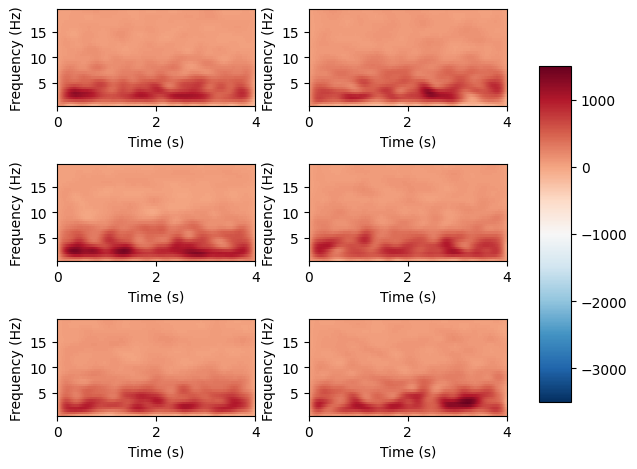

In [86]:
fs = 250
freqs = np.arange(0.5, 20., .5)
n_cycles = freqs

times = np.linspace(0, 4, np.array(epochs).shape[2])

power_1 = mne.time_frequency.tfr_array_morlet(epochs[np.where(groundtruth == 1.)[0], :, :], sfreq=fs,
                                                freqs=freqs, n_cycles=n_cycles,
                                                output='avg_power')
power_2 = mne.time_frequency.tfr_array_morlet(epochs[np.where(groundtruth == 2.)[0], :, :], sfreq=fs,
                                                freqs=freqs, n_cycles=n_cycles,
                                                output='avg_power')

mne.baseline.rescale(power_1, times, (None, 0), mode='mean', copy=False)
mne.baseline.rescale(power_2, times, (None, 0), mode='mean', copy=False)

power = np.stack([power_1, power_2])
x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(n_channels, 2)
for j in range(2):
    for i in range(n_channels):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        # ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='Time (s)', ylabel='Frequency (Hz)')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()


# Test on Dataset

In [10]:
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import MAMEM3
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import SSVEP
from moabb.pipelines import SSVEP_CCA


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

ModuleNotFoundError: No module named 'moabb'

In [ ]:
subj = [1, 3]
dataset = MAMEM3()
dataset.subject_list = subj

In [ ]:
paradigm = SSVEP(fmin=3, fmax=15, n_classes=3)

In [ ]:
interval = dataset.interval
freqs = paradigm.used_events(dataset)

pipeline = {}
pipeline["CCA"] = make_pipeline(SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=3))

In [ ]:
sessions = dataset.get_data(subjects=[3])
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[3])

In [ ]:
overwrite = True  # set to True if we want to overwrite cached results

evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=dataset, suffix="examples", overwrite=overwrite
)
results = evaluation.process(pipeline)

print(results.head())